In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:2px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:10pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:11pt;padding:4px;}
table.dataframe{font-size:10px;}
</style>
"""))

# ※ ①naver open API를 활용하여 네이버지식인 "전주여행"과 "경주여행"을 검색(re ? ) -> ②품사태깅 백업 -> ③명사만 추출 -> ④빈도분석(DataFrame) -> ⑤빈도 시각화(워드클라우드, Text) ->⑥ Word2Vec

# 1. 네이버 open API를 활용하여 검색 추출
- 검색어, no, titlem link, description, title + ' ' + description(total_text)

In [156]:
#conda install python-dotenv
import requests
import pandas as pd
import json
from dotenv import load_dotenv
import os
from konlpy.tag import Hannanum, Kkma, Komoran, Okt
from html import unescape
import re
import time
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import cv2
from wordcloud import STOPWORDS
from wordcloud import WordCloud
from mecab import MeCab
os.getcwd()
load_dotenv()

True

In [82]:
def get_naver_kin(keyword, total_cnt):
    import time
    all_items = []
    start = 1
    
    while len(all_items) < total_cnt:
        display = min(100, total_cnt - len(all_items))
        
        client_id = os.getenv('client_ID')
        client_secret = os.getenv('Client_Secret')
        url = f'https://openapi.naver.com/v1/search/kin.json?query={keyword}&display={display}&start={start}'
        headers = {'X-Naver-Client-Id': client_id, 'X-Naver-Client-Secret': client_secret}
        
        response = requests.get(url, headers=headers)
        items = response.json()['items']
        
        if not items:
            break
        all_items.extend(items)   
        start += display
        time.sleep(0.1) 

    items_list = []
    for i, item in enumerate(all_items, 1):
        title = item['title'].replace('<b>', ' ').replace('</b>', ' ')
        link = item['link']
        description = item['description'].replace('<b>', ' ').replace('</b>', ' ')
        description = unescape(description) # html 특수문자 처리(&lt; -> <로 대체)
        description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
        description = re.sub('\s+', ' ', description)
        items_list.append({'query':keyword,
                      'no':i,
                      'title':title,
                      'link':link,
                      'description':description,
                      'total_text':title+ ' ' + description})
    
    return items_list

In [87]:
kj_data = get_naver_kin('경주여행', 500)
kj_df = pd.DataFrame(kj_data)
kj_df.to_csv('data/naver_kin_kj.csv', index=False, sep='\t')
jj_data = get_naver_kin('전주여행', 500)
jj_df = pd.DataFrame(jj_data)
jj_df.to_csv('data/naver_kin_jj.csv', index=False, sep='\t')

In [162]:
total_df = pd.concat([kj_df, jj_df])
total_df.to_csv('data/naver_kin_total.csv', index=False, sep='\t')
total_df['no'] = range(1, len(total_df) + 1)

In [163]:
total_df

,query,no,title,link,description,total_text
0,경주여행,1,추석에 경주 여행,https://kin.naver.com/qna/detail.naver?d1id=9&...,추석에 경주 여행 가는거 어떻게 생각하시나요 서울에서 버스를 타고 갈 경우 버스가 ...,추석에 경주 여행 추석에 경주 여행 가는거 어떻게 생각하시나요 서울에서 버스를 ...
1,경주여행,2,1박2일 경주 여행 일정 짜주세요,https://kin.naver.com/qna/detail.naver?d1id=9&...,1박2일 경주 여행 일정 짜주세요 질문자님 경주에서의 1박 2일 여행을 계획 중이시...,1박2일 경주 여행 일정 짜주세요 1박2일 경주 여행 일정 짜주세요 질문자님 경...
2,경주여행,3,어머니랑 1박2일 경주여행,https://kin.naver.com/qna/detail.naver?d1id=9&...,이제 5월달 어버이날을 위해 어머니랑 경주 여행 을 할려고합니다 놀러갈데는 다 정했...,어머니랑 1박2일 경주여행 이제 5월달 어버이날을 위해 어머니랑 경주 여행 을 ...
3,경주여행,4,경주 여행,https://kin.naver.com/qna/detail.naver?d1id=9&...,5월6 7 8일 경주 여행 을 가는데요 동궁과월지와 월정교 야경을 보고 싶은데 7일...,경주 여행 5월6 7 8일 경주 여행 을 가는데요 동궁과월지와 월정교 야경을 보...
4,경주여행,5,경주여행 30만원,https://kin.naver.com/qna/detail.naver?d1id=9&...,경주 여행 2박3일 남자친구랑 가는데 숙소랑 ktx비는 다 냈고 제 개인적으로 3...,경주여행 30만원 경주 여행 2박3일 남자친구랑 가는데 숙소랑 ktx비는 다 ...
...,...,...,...,...,...,...
495,전주여행,996,전주 분들~~ 전주 맛집 추천해주세용,https://kin.naver.com/qna/detail.naver?d1id=8&...,부모님과 전주 여행 을 가려고하는데 진짜 찐 맛집좀 추천해주세요 일단 아래에 리스트...,전주 분들~~ 전주 맛집 추천해주세용 부모님과 전주 여행 을 가려고하는데 진짜 ...
496,전주여행,997,"전주 ,군산 여행 코스",https://kin.naver.com/qna/detail.naver?d1id=9&...,전주 객사 전주 동물원 선택 가족 여행 코스 어린 아이들을 동반한 여행 이라면 추...,"전주 ,군산 여행 코스 전주 객사 전주 동물원 선택 가족 여행 코스 어린 아이들..."
497,전주여행,998,전주여행 갈려구하는데 가볼만한곳 어디있,https://kin.naver.com/qna/detail.naver?d1id=12...,전주여행 갈려구하는데 가볼만한곳 어디있나요 알려주삼 안녕하세요 지어져 있고요 전북...,전주여행 갈려구하는데 가볼만한곳 어디있 전주여행 갈려구하는데 가볼만한곳 어디있나...
498,전주여행,999,전주 여행 코스,https://kin.naver.com/qna/detail.naver?d1id=9&...,가려고 찾아놓은 곳 나열할테니 전주 지리 잘 아시는 분 동선 파악해서 코스 좀 짜...,전주 여행 코스 가려고 찾아놓은 곳 나열할테니 전주 지리 잘 아시는 분 동선 ...


# 2.

In [88]:
kj_df = pd.read_csv('data/naver_kin_kj.csv', sep='\t')
jj_df = pd.read_csv('data/naver_kin_jj.csv', sep='\t')
total_df = pd.read_csv('data/naver_kin_total.csv', sep='\t')

In [134]:
kj_df_pos = '\''.join(kj_df['total_text'].tolist())
jj_df_pos = '\''.join(jj_df['total_text'].tolist())
total_df_pos = '\''.join(total_df['total_text'].tolist())

In [164]:
analyzer = MeCab()
stopwords = ['전주','경주','여행']
select_pos = ['NNG', 'NNP'] 
df_list = total_df[['query','no','total_text']].values.tolist()

In [176]:
postagged_lst = []
for i, row in enumerate(df_list):
    query = row[0]
    no = row[1]
    text = row[2]
    text_pos = analyzer.pos(text)
    # analyzer가 MeCab이 아닐 경우 시간이 좀 걸려서 250개마다 로그 출력
#     if i%250==0:
#         print("{}의 {}번째 품사태깅 결과 {}개 저장중".format(query, 
#                                                 no, 
#                                                 len(text_pos), end='\n\n'))
    for token, pos in text_pos:
        # if token not in stopwords and pos in select_pos: 라고 하면 명사만 추출
        if token not in stopwords and len(token)>1: # 모든 품사를 우선 다 넣고 나중에 빼려면
            postagged_lst.append({'query':query,
                                 'no':no,
                                 'token':token,
                                 'pos':pos})
df_postagged = pd.DataFrame(postagged_lst)
df_postagged

,query,no,token,pos
0,경주여행,1,추석,NNG
1,경주여행,1,추석,NNG
2,경주여행,1,어떻,VA
3,경주여행,1,생각,NNG
4,경주여행,1,나요,EF
...,...,...,...,...
25387,전주여행,1000,세요,EP+EF
25388,전주여행,1000,먹거리,NNG
25389,전주여행,1000,등등,NNB
25390,전주여행,1000,목포,NNP


In [166]:
df_postagged.to_csv('data/naver_kin_pos.csv', index=False, sep='\t')

# 3.

In [135]:
kj_pos_NN = [token for token, tag in komoran.pos(kj_df_pos) if tag in ('NNG','NNP')]
jj_pos_NN = [token for token, tag in komoran.pos(jj_df_pos) if tag in ('NNG','NNP')]
total_pos_NN = [token for token, tag in komoran.pos(total_df_pos) if tag in ('NNG','NNP')]

In [268]:
total = df_postagged.loc[df_postagged['pos'].isin(['NNP','NNG']),
                        ['query','token','pos']]
total.head()

,query,token,pos
0,경주여행,추석,NNG
1,경주여행,추석,NNG
3,경주여행,생각,NNG
5,경주여행,서울,NNP
7,경주여행,버스,NNG


In [269]:
total.to_csv('data/naver_kin_pos_nouns.csv', index=False, sep='\t')

# 4.

In [175]:
total.groupby(['query','token'], as_index=False)['pos'].count()

,query,token,pos
0,경주여행,가거,1
1,경주여행,가격,6
2,경주여행,가격대,1
3,경주여행,가능,17
4,경주여행,가려,1
...,...,...,...
2473,전주여행,휴가,3
2474,전주여행,휴가철,2
2475,전주여행,휴무,1
2476,전주여행,흐노,1


In [169]:
total_grp = total.groupby('query')['token'].value_counts()
total_grp

query  token
경주여행   코스       368
       추천       260
       숙소        98
       일정        90
       친구        90
               ... 
전주여행   후회         1
       휠체어        1
       휴무         1
       흐노         1
       흥미         1
Name: token, Length: 2478, dtype: int64

In [170]:
df_token_grp = total_grp.reset_index(name='token_count')
df_token_grp.head()

,query,token,token_count
0,경주여행,코스,368
1,경주여행,추천,260
2,경주여행,숙소,98
3,경주여행,일정,90
4,경주여행,친구,90


In [171]:
df_gj = df_token_grp.loc[df_token_grp['query']=='경주여행', ['token','token_count']]
df_jj = df_token_grp.loc[df_token_grp['query']=='전주여행', ['token','token_count']]
df_gj.shape, df_jj.shape

((1222, 2), (1256, 2))

In [172]:
df_gj

,token,token_count
0,코스,368
1,추천,260
2,숙소,98
3,일정,90
4,친구,90
...,...,...
1217,휴양,1
1218,휴일,1
1219,흥미,1
1220,희망,1


In [173]:
df_jj

,token,token_count
1222,코스,354
1223,한옥마을,263
1224,추천,234
1225,맛집,187
1226,여수,119
...,...,...
2473,후회,1
2474,휠체어,1
2475,휴무,1
2476,흐노,1


# 5.

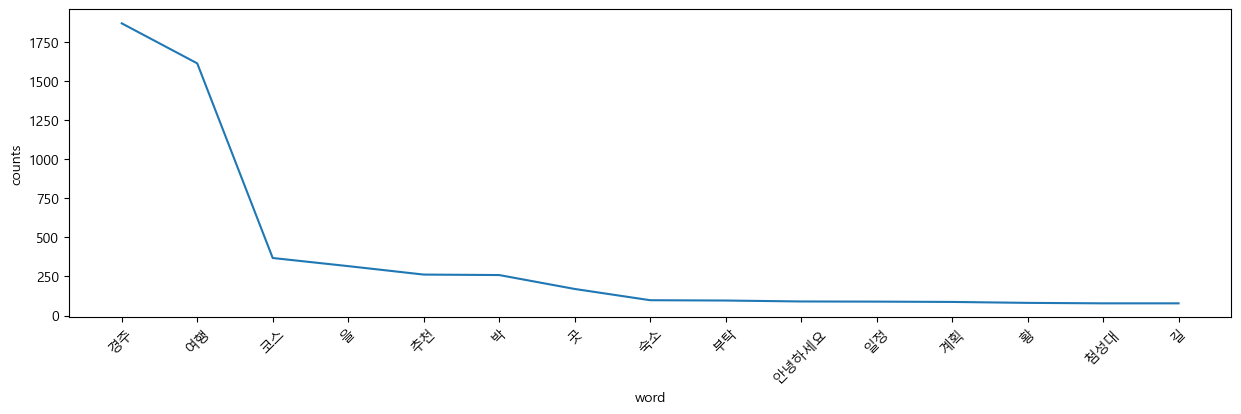

In [230]:
import nltk
df_gj = total[total['query'].str.contains('경주')]['token'].tolist()
data_text_gj = nltk.Text(kj_pos_NN)
word, counts = zip(*data_text_gj.vocab().most_common(15))
plt.figure(figsize=(15,4))
plt.plot(word, counts)
plt.xticks(rotation=45)
plt.xlabel('word')
plt.ylabel('counts')
plt.show()

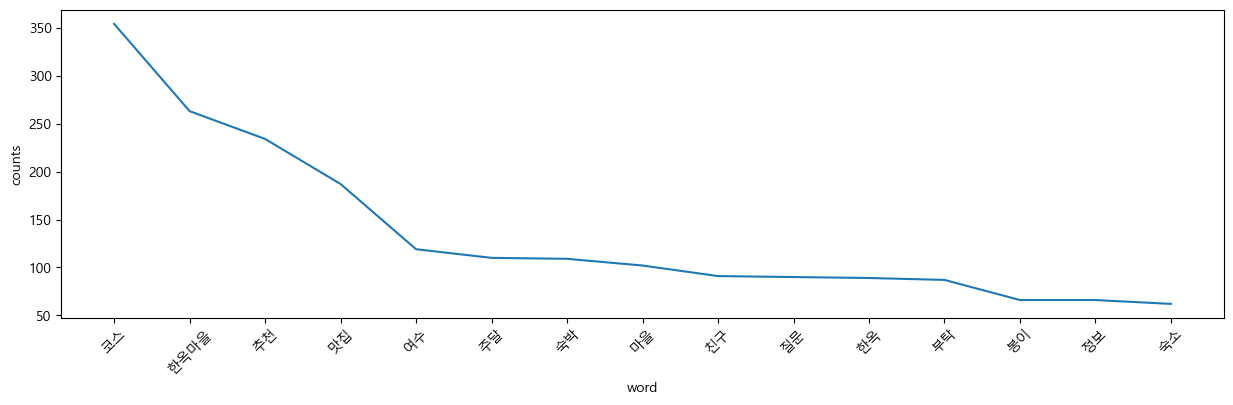

In [231]:
df_jj =total[total['query'].str.contains('전주')]['token'].tolist()
data_jj = nltk.Text(df_jj)
word, counts = zip(*data_jj.vocab().most_common(15))
plt.figure(figsize=(15,4))
plt.plot(word, counts)
plt.xticks(rotation=45)
plt.xlabel('word')
plt.ylabel('counts')
plt.show()

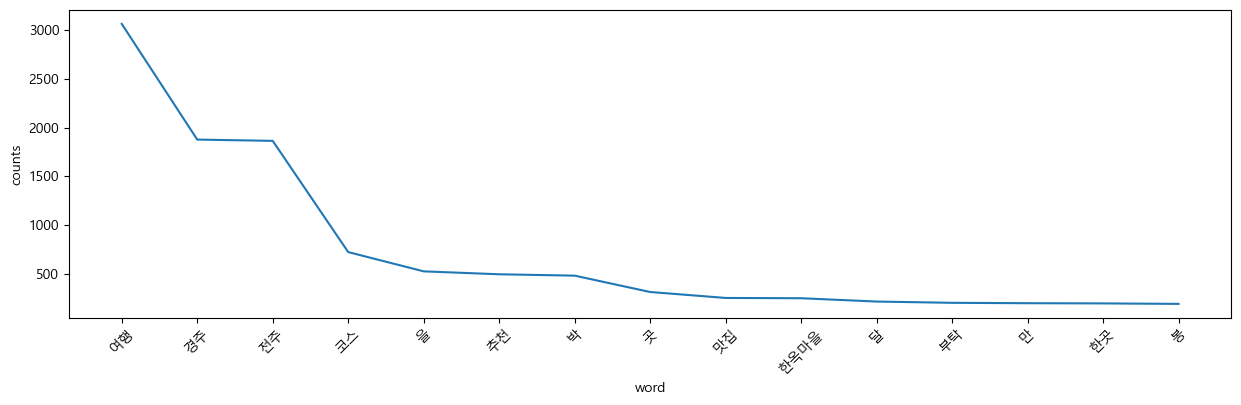

In [270]:
df_total= total['token'].tolist()
data_total = nltk.Text(total_pos_NN)
word, counts = zip(*data_total.vocab().most_common(15))
plt.figure(figsize=(15,4))
plt.plot(word, counts)
plt.xticks(rotation=45)
plt.xlabel('word')
plt.ylabel('counts')
plt.show()

In [119]:
불용어 = {'경주','전주','여행','추천'}

In [234]:
kj_pos_join = ' '.join(df_gj)
jj_pos_join = ' '.join(df_jj)
total_pos_join = ' '.join(df_total)

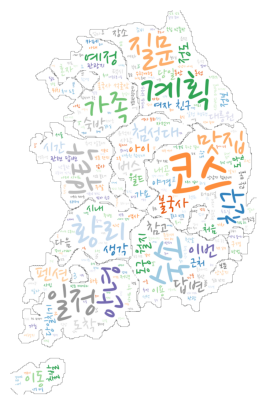

In [290]:
mask2 = cv2.imread('data/south_korea.png', 
                 )
mask2.shape
wordcloud = WordCloud(
                    font_path='data/NanumPenScript-Regular.ttf',
                    background_color='white', 
                    max_words=300,  
                    relative_scaling=0.4, 
                    colormap= 'tab20c', 
                    contour_color='gray',
                    stopwords=불용어,
                    mask=mask2,
                    contour_width=1
                    )
wordcloud.generate(kj_pos_join)
plt.figure(figsize=(20,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

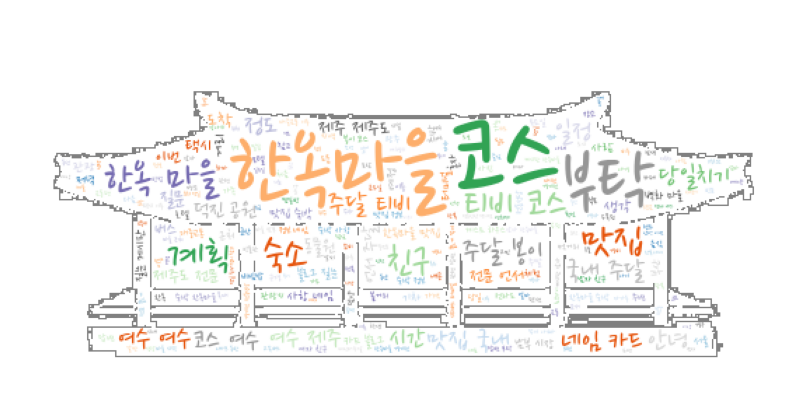

In [289]:
mask2 = cv2.imread('data/korea-house-black-fill.png', 
          
                 )
mask2.shape
wordcloud = WordCloud(
                    font_path='data/NanumPenScript-Regular.ttf',
                    background_color='white', 
                    max_words=300,  
                    relative_scaling=0.4,  
                    colormap= 'tab20c', 
                    contour_color='gray',
                    stopwords=불용어,
                    mask=mask2,
                    contour_width=1
                    )
wordcloud.generate(jj_pos_join)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

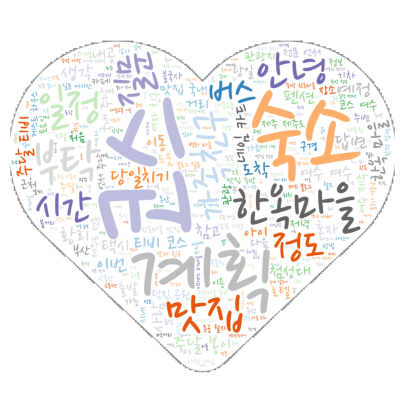

In [282]:
mask2 = cv2.imread('data/heart.jpg', 
                
                 )
mask2.shape
wordcloud = WordCloud(
                    font_path='data/NanumPenScript-Regular.ttf',
                    background_color='white', 
                    max_words=300, 
                    relative_scaling=0.4,
                    colormap= 'tab20c', 
                    contour_color='gray',
                    stopwords=불용어,
                    mask=mask2,
                    contour_width=1
                    )
wordcloud.generate(total_pos_join)
plt.figure(figsize=(18,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 6.

In [274]:
from gensim.models import Word2Vec
df_tt = [total['token'].values.tolist()]
model = Word2Vec(df_tt, 
                window=10,
                min_count=2,
                workers=-1,  
                )

In [288]:
model.wv.most_similar('식사')

[('거주', 0.2843840420246124),
 ('의견', 0.27471140027046204),
 ('출발', 0.25662481784820557),
 ('할머니', 0.2506680488586426),
 ('예산', 0.2476164549589157),
 ('대체', 0.24005773663520813),
 ('가려', 0.22514338791370392),
 ('오픈', 0.22453434765338898),
 ('대표', 0.22335213422775269),
 ('봄바람', 0.22058100998401642)]